# <center>Contrastive Learning</center>

### <center>Using SimCLR to illustrate the principles of self-supervised contrastive learning (CL)</center>

<center>Nick Glaser</center>


## CL - Introduction

- What's the need for CL?
  - Leverage large amounts of unlabeled data
  - Build _good_ transfer learning models
    - [Cross-entropy-trained models generally have suboptimal transfer performance](https://arxiv.org/abs/2103.13517)
    - [Transferability depends on many factors and is fragile in XEnt CV models](https://arxiv.org/abs/1411.1792)

[//]: # "Transferring between tasks is hard. Task similarity matters, data similarity matters. Classic classification & xent loss results in very semantically high-level features, e.g. petal-detectors - good for IRIS transfer, bad for medical images and planes. Can be combatted by using intermediate network layers instead of last but still run into issues, lower features might be too general, co-adapted neurons from original task cause instabilities, etc."


![image](./media/transfer_learning.jpeg)


![image](./media/imagenet_v_cl.jpeg)


- How can we frame a learning problem when we don't have labels for our data?
  - Intuition: one-versus-rest/ instance-level classification [Wu et al. 2018](https://arxiv.org/abs/1805.01978v1)
  - Learn embeddings that are similar for variations of the same sample while different for other examples


- Formalize a problem statement
  - Anchor $x$: Random sample drawn from data distribution
  - Positive sample $x^+$: Semantically similar sample to anchor
  - Negative sample $x^-$: Semantically disimilar sample to anchor
  - Encoder function $f: x \mapsto \textbf{h}$
  - **Goal**: learn $f$ such that $x$ and $x^+$ are closer in embedding space and $x$ and $x^-$ are far away, formally:

**Contrastive learning seeks to satisfy**:
$sim(\textbf{h}, \textbf{h}^+) > sim(\textbf{h}, \textbf{h}^-)$

- Negative examples are easy to obtain for instance-level discrimination, but how do we get good positive examples?
  - Pretext tasks!


![image](./media/augmentations.jpeg)


In [1]:
# some preprocessing code adapted from https://github.com/PyTorchLightning/lightning-bolts/
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from src.data_utils import util as data_util
from torchvision import transforms

# normalization stats for rgb channels
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)
cifar100_dim = 32

# augmentations, can modify values
normalize = transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
color_jitter = transforms.RandomApply(
    [transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8)
grayscale = transforms.RandomGrayscale(p=0.2)
gauss_blur = transforms.RandomApply([data_util.GaussianBlur2()], p=0.5)
resized_crop = transforms.RandomResizedCrop(size=cifar100_dim)

# allowed transforms
transform_dict = {
    'horizontal_flip': horizontal_flip,
    'color_jitter': color_jitter,
    'grayscale': grayscale,
    'gauss_blur': gauss_blur,
    'resized_crop': resized_crop
}

transform_widget = widgets.SelectMultiple(
    options=transform_dict.keys(),
    value=['resized_crop', 'color_jitter', 'grayscale', 'gauss_blur'],
    description='Data Transforms',
    disabled=False
)

transform_widget


SelectMultiple(description='Data Transforms', index=(4, 1, 2, 3), options=('horizontal_flip', 'color_jitter', …

In [2]:
# fetch widget values and close widget
selected_transforms = transform_widget.value
print(selected_transforms)
transform_widget.close()

# training transforms for local views
transf_list = [transform_dict[transf] for transf in selected_transforms]
train_transform = transforms.Compose(
    transf_list + [transforms.ToTensor(), normalize])

# transform for global view
eval_transform = transforms.Compose([transforms.Resize((int(cifar100_dim*0.1 + cifar100_dim))),
                                    transforms.CenterCrop(cifar100_dim),
                                    transforms.ToTensor(), normalize])


def contrastive_transform(sample):
    x_i = train_transform(sample)
    x_j = train_transform(sample)

    return x_i, x_j, eval_transform(sample), transforms.ToTensor()(sample)


('resized_crop', 'color_jitter', 'grayscale', 'gauss_blur')


In [9]:
cifar_100_train = data_util.CIFAR100CL(root='../data/raw/',
                                       train=True,
                                       transform=contrastive_transform,
                                       download=True
                                       )

cifar_100_test = data_util.CIFAR100CL(root='../data/raw/',
                                      train=False,
                                      transform=contrastive_transform,
                                      download=True
                                      )

train_iter = iter(cifar_100_train)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


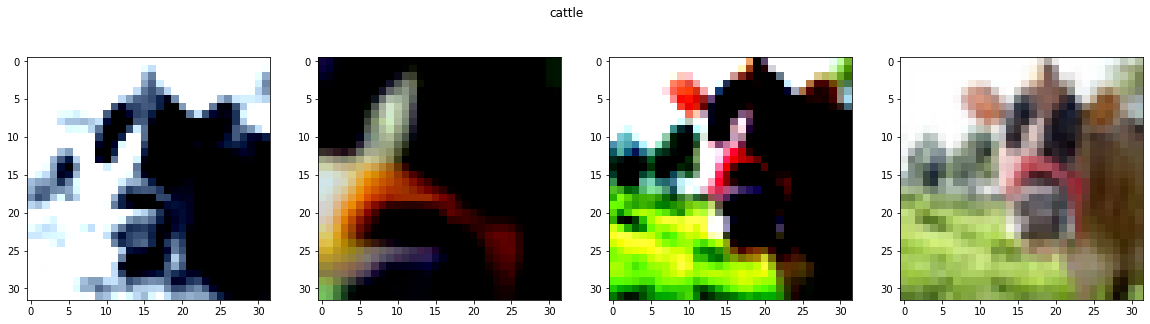

In [10]:
im, idx, lbl = next(train_iter)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(cifar_100_train.classes[lbl])
for i in range(4):
    tmp = im[i].transpose(0, 2).transpose(0, 1)
    axs[i].imshow(tmp)
plt.show()


## SimCLR


<p float="left">
  <img src="./media/cl_overview.gif" width="315" />
  <img src="./media/simclr_overview.png" width="451" /> 
</p>


### How can we go about "maximizing agreement"?


![image](./media/agreement_office.jpeg)


- Measure of similarity $\text{sim}(.,.)$: cosine similarity
  **$\mathrm{sim}(\bm u,\bm v) = \bm u^\top \bm v / \lVert\bm u\rVert \lVert\bm v\rVert$**

[//]: # "l2 norm applied for cosine similarity - as opposed to in dot product - is form of regularization and thus might help restrict network. SimCLR results show that using dot product improves CL task performance but degrades transfer performance -> overfitting"

- Loss to be minimized:
  #### $\mathcal{L}_{(i,j)} = - \log\frac{\exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(\mathbf{z}_i, \mathbf{z}_k) / \tau)}$
- Toy example for a batch of 2 examples (part of [this excellent blog post](https://medium.datadriveninvestor.com/simclr-part-2-the-encoder-projection-head-and-loss-function-809a64f30d4a)):
  - Transform and encode both examples to obtain $z_1, z_2, z_3, z_4$
  - Let's focus on just $z_1$ and calculate all pairwise similarities:
    - $a = \mathrm{sim}(\bm z_1,\bm z_2)$
    - $b = \mathrm{sim}(\bm z_1,\bm z_3)$
    - $c = \mathrm{sim}(\bm z_1,\bm z_4)$
  - In order to maximize a while minimizing b and c, and easy loss could be:
    ### $\frac{b+c}{a}$ → $\frac{e^{b}+e^{c}}{e^{a}}$ → $1 + \frac{e^{b}+e^{c}}{e^{a}}$ → $\frac{e^{a}+e^{b}+e^{c}}{e^{a}}$
  - And now to arrive at the cross-entropy part:
    ### $\log(\frac{e^{a}+e^{b}+e^{c}}{e^{a}})$ → $\log((\frac{e^{a}}{e^{a}+e^{b}+e^{c}})^{-1})$ → $-\log(\frac{e^{a}}{e^{a}+e^{b}+e^{c}})$
  - Add temperature scaling and you have the NT-XEnt loss for one of the embeddings of a single example:
    ### $-\log(\frac{e^\frac{{a}}{t}}{e^\frac{{a}}{t}+e^\frac{{b}}{t}+e^\frac{{c}}{t}})$
- Uniquely desirable property of this loss:
  - Implicitly weighs "hard negatives" - negatives with high similarity to the anchor - highly


In [6]:
# use pytorch-lightning wrapper
import math
import torch
import torch.optim as optim
from torch import Tensor, nn
import torch.utils.data as data
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl
from pl_bolts.optimizers.lars import LARS
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from src.backend import model_zoo


# For multi-gpu training
class SyncFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, tensor):
        ctx.batch_size = tensor.shape[0]

        gathered_tensor = [torch.zeros_like(tensor) for _ in range(torch.distributed.get_world_size())]

        torch.distributed.all_gather(gathered_tensor, tensor)
        gathered_tensor = torch.cat(gathered_tensor, 0)

        return gathered_tensor

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        torch.distributed.all_reduce(grad_input, op=torch.distributed.ReduceOp.SUM, async_op=False)

        idx_from = torch.distributed.get_rank() * ctx.batch_size
        idx_to = (torch.distributed.get_rank() + 1) * ctx.batch_size
        return grad_input[idx_from:idx_to]


# ReLU projection head
class NonlinProjection(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim, bias=False),
        )

    def forward(self, x):
        x = self.model(x)
        return F.normalize(x, dim=1)


# main framework
class SimCLR(LightningModule):
    def __init__(self,
                 hidden_dim=2048,
                 proj_dim=128,
                 lr=1e-3,
                 temperature=0.1,
                 weight_decay=1e-6,
                 max_epochs=500,
                 encoder=None,
                 optim='lars'):
        super().__init__()
        self.save_hyperparameters()

        try:
            assert self.hparams.temperature > 0.
        except AssertionError:
            exit('Temperature must be > 0.0.')

        # TODO: implement more robust/ dynamic way of specifying encoder and hidden_dim
        if encoder:
            self.encoder = encoder
        else:
            self.encoder = model_zoo.resnet18(width=0.5)
            self.hparams['hidden_dim'] = 2048

        self.head = NonlinProjection(
            input_dim=self.hparams.hidden_dim, output_dim=self.hparams.proj_dim)

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch, mode='train'):
        # 3rd image for online eval, 4th unprocessed image
        # idx is for memory bank or momemntum encoder, irrelevant here
        (img1, img2, _, raw), idx, y = batch

        if mode != 'train':
            # embed the more lightly augmented image
            h_val = self(_)
            z_val = self.head(h_val)
            
            self.logger.experiment.add_embedding(z_val, metadata=y.tolist(), label_img=raw, tag='Val Projection')

        # get h embeddings
        h1 = self(img1)
        h2 = self(img2)

        # get z projections
        z1 = self.head(h1)
        z2 = self.head(h2)

        loss = self.nt_xent_loss(z1, z2, self.hparams.temperature, mode=mode)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, mode='train')

        self.log('train_loss', loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, mode='valid')

        self.log('valid_loss', loss, on_step=True, on_epoch=False)
        return loss

    def configure_optimizers(self):
        # paper default
        if self.hparams.optim == 'lars':
            optimizer = LARS(
                self.parameters(),
                lr=self.hparams.lr,
                momentum=0.9,
                weight_decay=self.hparams.weight_decay,
                trust_coefficient=0.001,
            )
        # vanilla adam
        elif self.hparams.optim == 'adam':
            optimizer = torch.optim.Adam(
                self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        # adam with momentum
        elif self.hparams.optim == 'adamw':
            optimizer = optim.AdamW(
                self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        else:
            raise NotImplementedError(
                f'Optimizer {self.hparams.optim} not supported.')

        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )

        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

    def nt_xent_loss(self, out_1, out_2, temperature, eps=1e-6, mode='train'):
        """
        assume out_1 and out_2 are l2 normalized
        out_1: [batch_size, dim]
        out_2: [batch_size, dim]
        """
        # gather representations in case of distributed training
        # out_1_dist: [batch_size * world_size, dim]
        # out_2_dist: [batch_size * world_size, dim]
        if torch.distributed.is_available() and torch.distributed.is_initialized():
            out_1_dist = SyncFunction.apply(out_1)
            out_2_dist = SyncFunction.apply(out_2)
        else:
            out_1_dist = out_1
            out_2_dist = out_2

        # out: [2 * batch_size, dim]
        # out_dist: [2 * batch_size * world_size, dim]
        out = torch.cat([out_1, out_2], dim=0)
        out_dist = torch.cat([out_1_dist, out_2_dist], dim=0)

        # cov and sim: [2 * batch_size, 2 * batch_size]
        # neg: [2 * batch_size]
        cov = torch.mm(out, out_dist.t())
        sim = torch.exp(cov / temperature)

        # loss denominator
        neg = sim.sum(dim=-1)
        # from each row, subtract e^(1/temp) to remove similarity measure for x1.x1 -> easier than masking
        row_sub = Tensor(neg.shape).fill_(
            math.e ** (1 / temperature)).to(neg.device)
        # clamp for numerical stability
        neg = torch.clamp(neg - row_sub, min=eps)

        # loss numerator
        # Positive similarity, pos becomes [2 * batch_size]
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        pos = torch.cat([pos, pos], dim=0)

        loss = -torch.log(pos / (neg + eps)).mean()

        # calculate accuracy metrics
        # copy similarity matrix, no gradients needed for this part so detach
        sim_eval = sim.detach()
        # first find values to mask where similarity was calculated with itself& zero out
        self_mask = torch.eye(sim_eval.shape[0], dtype=torch.bool, device=sim_eval.device)
        sim_eval = sim_eval.masked_fill(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=sim_eval.shape[0] // 2, dims=0)
        # Get ranking position of positive example by logit score
        comb_sim = torch.cat(
            [sim_eval[pos_mask][:, None], sim_eval.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        # positive sample ranked first
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean(), on_step=True, on_epoch=False)
        # positive sample ranked in top 5 
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean(), on_step=True, on_epoch=False)
        # mean position of positive sample among entire batch
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean(), on_step=True, on_epoch=False)

        return loss


In [11]:
def simclr_trainer(train_ds, val_ds, batch_size=128, max_epochs=500, **kwargs):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir='../results/simclr_demo/lightning_logs')
    trainer = Trainer(
        default_root_dir='../results/simclr_demo/model_checkpoints',
        gpus=0,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
            LearningRateMonitor("epoch"),
        ],
        progress_bar_refresh_rate=1,
        logger=tb_logger,
        log_every_n_steps=2
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
        drop_last=True)

    valid_loader = data.DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
        drop_last=True)

    pl.seed_everything(13)

    model = SimCLR(max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, valid_loader)
    
    # load& return best model after training is complete
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [12]:
simclr_model = simclr_trainer(cifar_100_train, cifar_100_test, batch_size=128)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 13

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | ResNet           | 116 M 
1 | head    | NonlinProjection | 4.5 M 
---------------------------------------------
121 M     Trainable params
0         Non-trainable params
121 M     Total params
484.264   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13
/Users/yannikglaser/miniforge3/envs/ssl_demo/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

### Let's look at some of the results